## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 2: Algoritmos de entrenamiento y aproximación de esperanzas condicionales**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: COMPLETAR**



**Instrucciones:**

- **Fecha de entrega:** **31 de mayo de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

#### **Ejercicio 1: Algoritmo Adam**

En el presente [artículo](https://arxiv.org/abs/1412.6980) se introduce el algoritmo de optimización estocástica Adam (por Adaptative Moment Estimation), el objetivo de este ejercicio es implementar dicho algoritmo y utilizarlo para entrenar redes neuronales, para ello se explorarán todos los detalles de implementación de una red neuronal, con ciertas simplificaciones.

Utilizaremos Adam para entrenar una red neuronal de 1 capa oculta de $\mathbb{R}$ en $\mathbb{R}$, de ancho $batch_size$, con su realización dada por

$$ \Phi_\theta (x) = W_2 \cdot \sigma (W_1 \cdot x + b_1) + b_2 $$

Consideraremos $\sigma(x) = \text{tanh}(x)$ y $\theta = (W_1, b_1, W_2, b_2)$, $W_1 \in \mathbb{R}^{batch_size \times 1}$, $b_1 \in \mathbb{R}^{batch_size}$, $W_2 \in \mathbb{R}^{1 \times batch_size}$, $b_2 \in \mathbb{R}$. En este caso codificaremos, los parámetros del sistema en un vector de $\mathbb{R}^{3N + 1}$ dado por

$$ \theta = (W_1, b_1, W_2, b_2)^T $$

Esto no es lo que hacen las librerías de aprendizaje profundo en la realidad, pero en este caso permite simplificar mucho los manejos de estructuras de datos utilizadas.

Para lo que sigue utilizaremos la librería ``autograd`` (instalada ya en Google Colab) que facilitará implementar la diferenciación automática (utilizada en las librerías más importantes de *deep learning*) para calcular facilmente el gradiente de la función de pérdida. Esta librería sobrescribe la librería ``numpy`` por lo que ahora utilizaremos esa librería con el sobrenombre ``np`` como si fuese la librería original.

In [51]:
# Numpy de autograd
import autograd.numpy as np

# Función de gradiente mediante diferenciación automática
from autograd import grad

# Permite utilizar isinstance y tuple en autograd
from autograd.builtins import isinstance, tuple

# Para graficar
import matplotlib.pyplot as plt

# Fijamos la semilla
np.random.seed(115)

# Módulo para anotar funciones
from typing import Union

# Para hacer DataFrames
import pandas as pd

# Notas:
# Documentación de autograd: https://github.com/HIPS/autograd

Buscaremos ajustar la red neuronal a datos *sampleados* desde una función $\text{cos}(x)$ con cierto ruido gaussiano. Generemos los datos antes de empezar el ejercicio.

In [52]:
# Función a aproximar
def f_true(x):
    return np.cos(x)

In [53]:
xdim = 1  # Dimensión de input
Ndata = 20  # Cantidad de datos a samplear
ydim = 1  # Dimensión de output

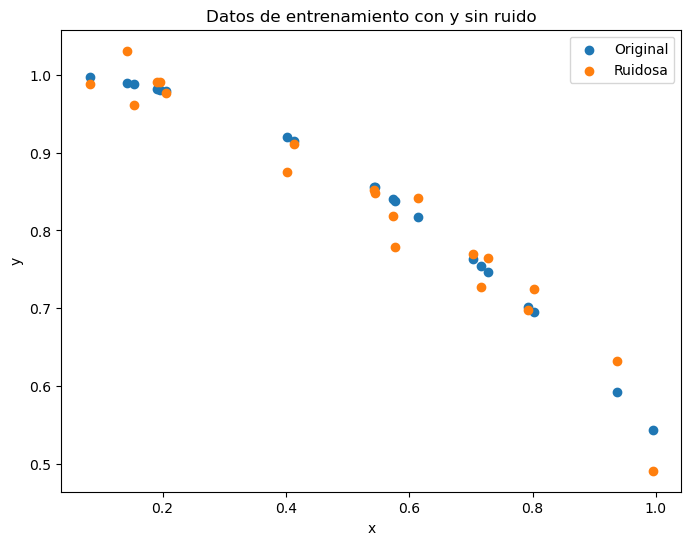

In [54]:
# Datos aleatorios
x_train = np.random.random((xdim, Ndata))

# Sampleo de datos
desv = 3e-2
y_train = f_true(x_train) + desv * np.random.randn(*x_train.shape)

plt.figure(figsize=(8, 6))
plt.scatter(x_train.flatten(), f_true(x_train).flatten(), label="Original")
plt.scatter(x_train.flatten(), y_train.flatten(), label="Ruidosa")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos de entrenamiento con y sin ruido")
plt.legend()
plt.show()

#### **Ejercicio 1.1: Creación de una red neuronal de 1 capa oculta**

Cree una función en Python ``net(params, x)`` que dados los parámetros codificados en un arreglo de ``numpy`` tal como se mostró arriba y un conjunto de datos $x \in \mathbb{R}^{1 \times N_{data}}$ calcule el output de la red. Pruebe su función con parámetros inicializados aleatoriamente desde una uniforme estándar y el arreglo ``x_train`` creado antes.

##### **Solución Ejercicio 1.1.**

In [55]:
def net(params: np.array, x: np.array, sigma: callable = np.tanh) -> np.array:
    """
    Realisación de la red neuronal a una capa oculta, de ancho batch_size=(params.shape[0] - 1)/3, con dimensión de entrada y salida 1.

    En la capa de entrada, se aplica la función de activación tangente hiperbólica compuesta con la función afín
    Wa*x + ba, donde Wa son los primeros batch_size parámetros de params y ba los siguientes batch_size.
    De la segunda capa a la salida, se aplica la función afín Wb*x + bb (sin acivación), donde Wb son los siguientes batch_size parámetros
    de params, después de haber asignado Wa y ba, y bb es el último parametro.

    Se aplica esta red a cada dato de x.

    Args:
        params (np.array): Parámetros de la red neuronal.
        x (np.array): Datos de entrada de la red neuronal.

    Returns:
        np.array: Datos de salida de la red neuronal.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si x no es un np.array.
        AssertionError: Si el número de parámetros no es correcto.
        AssertionError: Si la dimensión de x no es correcta.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(x, np.ndarray), "x debe ser un np.array."
    assert params.shape[0] % 3 == 1, "El número de parámetros no es correcto."
    assert x.ndim == 1 or (
        x.ndim == 2 and 1 in x.shape
    ), "La dimensión de x no es correcta."

    shape = x.shape
    x = np.squeeze(x)
    params = np.squeeze(params)

    batch_size = int((params.shape[0] - 1) / 3)
    Wa = params[:batch_size]
    ba = params[batch_size : 2 * batch_size]
    Wb = params[2 * batch_size : 3 * batch_size]
    bb = params[3 * batch_size]

    def single_data_case(x: float) -> float:
        x = sigma(Wa * x + ba)
        x = Wb @ x + bb
        return x

    y = np.array([single_data_case(xi) for xi in x]).reshape(shape)

    return y

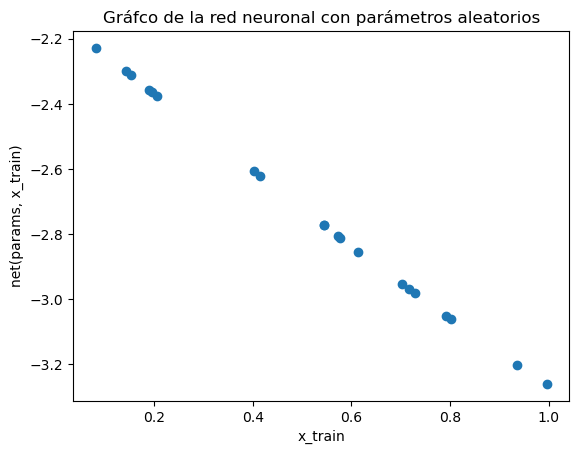

In [56]:
ancho = 30  # Ancho de la red neuronal

# Creamos un array de parámetros aleatorios mediante una uniforme estandard
params = np.random.uniform(-1, 1, size=(3 * ancho + 1))

y = net(params, x_train)

# Creamos el plto
plt.scatter(x_train, y)

# Agregamos labels
plt.xlabel("x_train")
plt.ylabel("net(params, x_train)")
plt.title("Gráfco de la red neuronal con parámetros aleatorios")

# Mostramos el plot
plt.show()

#### **Ejercicio 1.2: Creación de la función de pérdida por *batches***

La naturaleza estocástica del algoritmo proviene de que no se le entregan todos los datos de entrenamiento, sino que una muestra diferente en cada iteración de entrenamiento, dichas muestras las denotaremos *batches*. Implemente una función en Python ``loss(params)`` que dados unos parámetros ``params`` $\theta$ haga lo siguiente:

* Obtenga un subarreglo de tamaño $(1, N_{batches})$ de ``x_train`` de manera aleatoria y sin sustitución, digamos ``x_batch``.
* Obtenga el ``y_batch`` correspondiente.
* Calcule la pérdida cuadrática en este *batch*:

$$ L(\theta) = \sum_{i=1}^{N_{batch}} (y_i - \Phi_\theta (x_i)) $$

##### **Solución Ejercicio 1.2.**

In [57]:
def loss(
    params: np.array, x: np.array = x_train, y: np.array = y_train, batch_size: int = Ndata
) -> float:
    """
    Función que toma un np.array de parametros para la red neuronal, y un np.array de datos x e y, y calcula el error cuadrático medio
    de la red neuronal con los datos x e y, utilizando un batch de tamaño batch_size.

    Args:
        params (np.array): Parámetros de la red neuronal.
        x (np.array, optional): Datos de entrada de la red neuronal. Defaults to x_train.
        y (np.array, optional): Datos de salida de la red neuronal. Defaults to y_train.
        batch_size (int, optional): Tamaño del batch. Defaults to Nbatch.

    returns:
        float: Error cuadrático medio de la red neuronal con los datos x e y.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si x no es un np.array.
        AssertionError: Si y no es un np.array.
        AssertionError: Si batch_size no es un entero.
        AssertionError: Si el número de parámetros no es correcto.
        AssertionError: Si la dimensión de x no es correcta.
        AssertionError: Si las dimensiones de x e y no son compatibles.
        AssertionError: Si el tamaño del batch es muy grande.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(x, np.ndarray), "x debe ser un np.array."
    assert isinstance(y, np.ndarray), "y debe ser un np.array."
    assert isinstance(batch_size, int), "batch_size debe ser un entero."

    assert params.shape[0] % 3 == 1, "El número de parámetros no es correcto."
    assert x.ndim == 1 or (
        x.ndim == 2 and 1 in x.shape
    ), "La dimensión de x no es correcta."
    assert x.shape == y.shape, "Las dimensiones de x e y no son compatibles."
    assert batch_size <= np.squeeze(x).shape[0], "El tamaño del batch es muy grande."

    x = np.squeeze(x)
    y = np.squeeze(y)

    # Elejimos un batch aleatorio con probabilidad uniforme sobre x, sin substitucion
    indices = np.random.choice(len(x), size=batch_size, replace=False)
    x_batch = x[indices]

    # Obtenemos el y_batch correspondiente
    y_batch = net(params, x_batch)

    # Calculamos la perdida en el batch
    MSE = np.mean((y[indices] - y_batch) ** 2)

    return MSE


loss(params)

12.75526432285979

#### **Ejercicio 1.3: Cálculo del gradiente vía autodiferenciación y comparación con diferencias finitas**

Con la función ``grad`` de ``autograd`` calcule el gradiente de la función de pérdida antes creada, con tamaño de *batch* igual a ``Ndata``, es decir, la función de pérdida se vuelve determinista en este caso (ya que le pasamos todos los datos al tomar los batches sin sustitución. Compare en norma este gradiente con el cálculado mediante por diferencias finitas centradas

$$ \frac{\partial L}{ \partial \theta_j} (\theta) \approx \frac{L(\theta + \varepsilon e_j) - L(\theta - \varepsilon e_j)}{2 \varepsilon} $$

Para $\varepsilon \in \{ 10, 1, 0.1, 0.01 \}$, evaluado los gradientes en los mismo parámetros utilizados en la parte anterior.

##### **Solución Ejercicio 1.3.**

Para esta sección, usaremos un batch size igual a la cantidad de datos de entrenamiento, es decir, estos resultados son de caracter determinista en cuanto a la función de error.

In [58]:
# Cálculo de gradiente mediante diferencias finitas
def finite_diff_grad(params: np.array, eps: Union[int,float] = 1e-2) -> np.array:
    """
    Función que toma un np.array de parametros para la red neuronal, y calcula el gradiente de la función de perdida
    con respecto a los parametros mediante diferencias finitas.

    Args:
        params (np.array): Parámetros de la red neuronal.
        eps (float, optional): Tamaño del paso para las diferencias finitas. Defaults to 1e-2.

    Returns:
        np.array: Gradiente de la función de perdida con respecto a los parametros evaluada en params.

    Raises:
        AssertionError: Si params no es un np.array.
        AssertionError: Si eps no es un flotante.
    """

    assert isinstance(params, np.ndarray), "params debe ser un np.array."
    assert isinstance(eps, (int,float)), "eps debe ser un flotante."

    grad = np.zeros(params.shape)

    for i in range(len(params)):
        params[i] += eps
        loss_plus = loss(params)
        params[i] -= 2 * eps
        loss_minus = loss(params)
        params[i] += eps
        grad[i] = (loss_plus - loss_minus) / (2 * eps)

    return grad

eps = [10,1,0.1,0.01]

print(f"Valores del gradiente de la loss function mediente diferencias finitas para eps en {eps}:")
print()
finite_gradients = []
for e in eps:
    print(f"eps = {e}:")
    gradient = (e, finite_diff_grad(params, e))
    finite_gradients.append(gradient)
    print(gradient[1])
    print()

Valores del gradiente de la loss function mediente diferencias finitas para eps en [10, 1, 0.1, 0.01]:

eps = 10:
[-2.11403906e-01 -1.56876747e-01 -1.37890194e-01  2.06402201e-01
 -1.51640013e-01  6.68360947e-03 -3.01980179e-01 -5.73401625e-01
 -1.85401336e-01  2.86460612e-01 -4.19082276e-01  3.06469550e-01
  6.99554472e-01 -2.84935204e-01 -2.38612181e-01  2.06855949e-01
  4.49956242e-01  3.34165911e-01  3.52257663e-01  6.19646775e-01
  1.84515642e-01 -2.39811711e-01 -1.09390818e-01  1.94130046e-01
  3.20062969e-01  3.69472397e-01 -6.99637712e-01 -4.56167617e-01
 -4.60324414e-01  4.40246638e-01 -2.20144148e-01 -1.62068752e-01
 -1.44773938e-01  2.12850002e-01 -1.57359148e-01  6.89069636e-03
 -3.24657705e-01 -5.93592090e-01 -1.95666967e-01  2.95412701e-01
 -4.37074144e-01  3.17879307e-01  7.22039583e-01 -2.94332131e-01
 -2.45945073e-01  2.13778541e-01  4.78378889e-01  3.45614961e-01
  3.85844843e-01  6.45769766e-01  1.93603824e-01 -2.53999639e-01
 -1.13337040e-01  2.06338758e-01  3.31493

In [59]:
# Calculamos el gradiente mediante grad de autograd
grad_loss = grad(loss)

print("Gradiente de la función de pérdida mediante autograd:")
print()
auto_gradient = grad_loss(params)
print(auto_gradient)

Gradiente de la función de pérdida mediante autograd:

[-0.63797487 -0.78538301 -0.606906    0.86339518 -0.77097926  0.03564421
 -0.44843425 -2.40897568 -0.73638923  1.35707066 -2.20013428  1.65337225
  2.70167641 -1.5354887  -1.23500872  1.11738259  0.96739161  1.82066597
  0.33661383  3.20062729  0.64010022 -0.65151717 -0.58489519  0.96550851
  1.49099718  1.8077585  -2.85846396 -1.73340582 -1.16176759  2.35168898
 -1.33806646 -1.52660524 -1.10500586  1.78211212 -1.46756302  0.06769459
 -0.99208597 -4.75221185 -1.3311864   2.71010354 -3.86973368  2.99353344
  5.45716982 -2.84848219 -2.38421513  2.07445165  1.98797673  3.33518381
  0.79211495  5.90909702  1.23603878 -1.28435225 -1.09175639  1.66561997
  2.84696476  3.20683727 -5.26501463 -3.21156785 -2.47739673  4.38850797
 -4.22677538  1.00106356 -3.29401832 -2.83804271  0.33998119  0.37076623
  6.09572269  4.04734839  4.22017238 -2.04210626  2.85079399 -1.91649815
  2.7600643   0.56683478  1.33580677 -0.60560002 -5.80124389 -1.62485

Comparamos los resultados del gradiente mediente autograd y diferencias finitas para cada $\varepsilon$ especificado.

In [60]:
gradient_error = []

for e, finite_gradient in finite_gradients:
    error = np.linalg.norm(auto_gradient - finite_gradient)
    gradient_error.append((e, error))

gradient_error_df = pd.DataFrame(gradient_error, columns=["eps", "gradient error"])

print(gradient_error_df.to_string(index=False))

  eps  gradient error
10.00       15.428508
 1.00        2.819216
 0.10        0.034679
 0.01        0.000348


#### **Ejercicio 1.4: Implementación de Adam**

Vuelva a calcular el gradiente de la función de pérdida, pero ahora utilizando un tamaño de batch de $5$ (ahora sí se vuelve aleatoria la función de pérdida). Utilice 10000 iteraciones para el algoritmo y los mismos parámetros $\alpha, \beta_1, \beta_2, \varepsilon$ del artículo original. Grafique la evolución de la función de pérdida a través de las iteraciones en escala log-log (escala logarítmica en ambos ejes) y el resultado de la red en contraste con los datos y la función sin ruido evaluada en los puntos de entrenamiento.

##### **Solución Ejercicio 1.4.**

In [61]:
def ADAM(
    param0: np.array,
    f: callable,
    alpha: float = 0.001,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    max_iter: int = 1000,
    min_error=5e-5,
) -> np.array:
    """
    Función que recibe un np.array de parametros iniciales, una función de costo, y los hiperparámetros alpha, beta1, beta2 y eps
    para el optimizador ADAM, y retorna un np.array de parámetros optimizados para la función de costo f.

    Args:
        param0 (np.array): Parámetros iniciales.
        f (callable): Función de costo estocástica.
        alpha (float, optional): Cota superior para los pasos. Defaults to 0.001.
        beta1 (float, optional): Taza de decaimiento exponencial para el promedio de los gradientes. Defaults to 0.9.
        beta2 (float, optional): Taza de decaimiento exponencial para el promedio de los gradientes al cuadrado. Defaults to 0.999.
        eps (float, optional): Término de regularización. Defaults to 1e-8.

    Returns:
        np.array: Parámetros optimizados para la función de costo f.
    """

    m = [np.zeros_like(param0)]  # Inicializamos el primer momento estimado
    v = [np.zeros_like(param0)]  # Inicializamos el segundo momento estimado
    t = [0]  # Inicializamos el contador de pasos

    g = [None]
    m_hat = [None]
    v_hat = [None]

    params = [param0]

    stochastic_error = [f(params[-1])]

    while t[-1] < max_iter and f(params[-1]) > min_error:
        t.append(t[-1] + 1)
        g.append(
            grad(f)(params[-1])
        )  # Obtener gradiente c.r. al objetivo estocástico
        m.append(
            beta1 * m[-1] + (1 - beta1) * g[-1]
        )  # Actualizamos el primer momento estimado sesgado
        v.append(
            beta2 * v[-1] + (1 - beta2) * g[-1] ** 2
        )  # Actualizamos el segundo momento estimado sesgado
        m_hat.append(
            m[-1] / (1 - beta1 ** t[-1])
        )  # Calculamos el primer momento estimado corregido
        v_hat.append(
            v[-1] / (1 - beta2 ** t[-1])
        )  # Calculamos el segundo momento estimado corregido
        params.append(
            params[-1] - alpha * m_hat[-1] / (np.sqrt(v_hat[-1]) + eps)
        )  # Actualizamos los parámetros
        stochastic_error.append(f(params[-1]))
        print(f(params[-1]))

    return params[-1]  # Parametro resultante

In [62]:
f = lambda params: loss(params, batch_size = 5)

params_opt = ADAM(params, f)

print(f"error final: {loss(params_opt)}")

12.236279749053887
11.93283818206502
13.021544593043913
11.90273478708761
12.070756470889156
11.356018053211747
11.048860061212435
10.51329303193032
10.171927166010034
10.440058963156218
9.942049685112016
10.429557375580528
9.442479640139158
10.259729013766695
10.262603620241977
9.246008734309374
10.045307014229177
9.460795360697777
9.632037680057504
9.488899892597294
9.179911538941111
8.982397274355627
8.773172535258855
8.76583916280764
8.087692654573182
8.609817848606806
7.878564053723868
7.119822178554848
7.550399250268448
7.0125143686524165
7.073706762193622
7.5557070493540675
6.779520710115219
6.658130479260437
6.659367577241893
6.200979082871584
6.3619500189408615
6.547500111014917
6.52264630479749
5.61766749470228
5.715735292892452
5.900020731406614
5.876663058733974
5.587660131571407
5.648446891809004
5.483901963244487
5.507302358330726
5.395761528614431
5.223143909868147
4.909298156918868
4.995086747926651
4.832642067138822
4.643680209909952
4.473099269574372
4.562386341110479

### **Ejercicio 2: Aproximación de esperanzas condicionales vía redes neuronales**

Sean $X$, $Y$ variables aleatorias y $f$ una función continua, luego es sabido de clases que el problema de encontrar una función que minimice el error cuadrático medio

$$  \min_{f} \mathbb{E} [(Y - f(X))^2] $$

Viene dado por

$$ f(x) = \mathbb{E} [Y \, | \, X = x] $$

El objetivo de este ejercicio es ver numéricamente como una red neuronal entrenada para minimizar el error cuadrático medio de una muestra de puntos $\{x_i, y_i \}$ tales que $f(x_i ) = y_i$, con $f$ desconocida, en realidad se aproxima a la esperanza condicional con $X$ e $Y$ tales que $x_i \sim X$, $y_i \sim Y$.

Para este ejercicio consideremos $X$ con ley $\text{Unif}(-1,1)$, la función que buscamos aproximar será

$$ f(x) = e^{-2 x^2}$$

Y la ley de $Y$ supongamos que es $f(X) \, + \, \text{batch_size}(0, 0.1^2)$.

#### **Ejercicio 2.1: Generar datos de entrenamiento**

Samplee 100 puntos de la ley de $X$ dada antes y con ello obtenga 100 muestras aleatorias correspondientes de $Y$.

In [63]:
# Tu solución aquí

#### **Ejercicio 2.2: Cálculo de la esperanza condicional vía Montecarlo**

En este caso como es sabida la ley de $Y$ vía la función $f$ (en la realidad todo esto es desconocido) se puede calcular la esperanza condicional vía método de Montecarlo. Cree una función en Python que dado un $x \in [-1, 1]$ y una cantidad de muestras para la aproximación de Montecarlo, digamos $M$, calcule

$$ \mathbb{E} [Y \, | \, X = x] \approx \hat f = \frac{1}{M} \sum_{j=1}^M f(x) + w_j $$

Donde los $w_j$ vienen sampleados desde una $batch_size(0, 0.1^2)$. Realice 3 gráficos de $\hat f$ en $[-1, 1]$ uno utilizando $M=10$, $M=100$, $M=1000$ ¿qué observa cuando $M$ aumenta?

In [64]:
# Tu solución aquí

#### **Ejercicio 2.3: Observando la aproximación de una red neuronal**

Entrene una red neuronal de una sola capa oculta con pérdida cuadrática para que ajuste a los datos que usted generó en el ejercicio 2.1, puede utilizar la función de pérdida y el ancho que más le acomode (o que mejores resultados le entregue). Grafique la predicción de la red neuronal en $[-1, 1]$ y compare con el resultado del ejercicio 2.2.

*Indicación: Puede utilizar el código creado en el ejercicio 1, o bien, utilizar alguna librería como Pytorch, Tensorflow, etc.*

In [65]:
# Tu solución aquí